# Import thư viện

In [266]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Định nghĩa các hàm tiền xử lý

*Hàm tiền xử lý dữ liệu*

In [267]:
def extracting(df):
    # Xóa các cột không cần thiết
    df.drop(['link'], axis=1, inplace=True)

    # Chuyển đổi kiểu dữ liệu của cột 'genres' từ list sang string
    df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
    df['genres'] = df['genres'].apply(lambda x: sorted(x))
    df['genres'] = df['genres'].apply(lambda x: ','.join(x))
    
    return df

*Hàm chuyển đổi dữ liệu về dạng số*

In [268]:
def string_to_num(X_train, X_val, X_test, col):
    # Khởi tạo Label Encoder
    le = LabelEncoder()
    
    # Nếu cột trong tập train không có giá trị nào trong tập test thì thay thế bằng 'Unknown'
    for i in X_test[col].unique():
        if i not in X_train[col].unique():
            X_test[col].replace(i, 'Unknown', inplace=True)

    # Nếu cột trong tập train không có giá trị nào trong tập val thì thay thế bằng 'Unknown'
    for i in X_val[col].unique():
        if i not in X_train[col].unique():
            X_val[col].replace(i, 'Unknown', inplace=True)

    data = np.append(np.array(X_train[col].copy()), 'Unknown')

    # Fit Label Encoder
    le.fit(data)
    X_train[col] = le.transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
    X_test[col] = le.transform(X_test[col])

    return X_train, X_val, X_test

*Hàm xử lí dữ liệu trống*

In [269]:
def fillMissingData(data_train, data_val, data_test):
    # Các cột có giá trị trống
    eod_columns = ['publish_year', 'num_pages', 'page_format', 'publisher_count']
    eod_values = [data_train[col].mean() + 3*data_train[col].std() for col in eod_columns]
    for col, val in zip(eod_columns, eod_values):
        data_train[col].fillna(val, inplace=True)
        data_val[col].fillna(val, inplace=True)
        data_test[col].fillna(val, inplace=True)
    return data_train, data_val, data_test

*Hàm vẽ biểu đồ*

In [270]:
# Biểu đồ phân phối của các cột
def plotDistribution(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes] 
    for col, ax in zip(columns, axes):
        ax.hist(data[col], bins=50)
        ax.set_title(col)
    plt.show()  

# Biểu đồ box của các cột
def plotBox(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    for col, ax in zip(columns, axes):
        ax.boxplot(data[col])
        ax.set_title(col)
    plt.show()

*In ra các thông số đánh giá*

In [271]:
def printDescription(data, columns):
    for col in columns:
        print(data[col].describe())

*Hàm xử lí ngoại lệ*

In [272]:
def handleOutlier(data_train, data_val, data_test, skewedDists, gaussionDists):
    for col in skewedDists:
        IQR=data_train[col].quantile(0.75) - data_train[col].quantile(0.25)
        lower_bridge=data_train[col].quantile(0.25) - (IQR*3)
        upper_bridge=data_train[col].quantile(0.75) + (IQR*3)
        if skewedDists[col]:
            data_train.loc[data_train[col]>=upper_bridge,col]=upper_bridge
            data_val.loc[data_val[col]>=upper_bridge,col]=upper_bridge
            data_test.loc[data_test[col]>=upper_bridge,col]=upper_bridge
        else:
            data_train.loc[data_train[col]<=lower_bridge,col]=lower_bridge
            data_val.loc[data_val[col]<=lower_bridge,col]=lower_bridge
            data_test.loc[data_test[col]<=lower_bridge,col]=lower_bridge
        
    for col in gaussionDists:
        upper_boundary=data_train[col].mean() + 3 * data_train[col].std()
        lower_boundary=data_train[col].mean() - 3 * data_train[col].std()
        if gaussionDists[col]:
            data_train.loc[data_train[col]>=upper_boundary,col]=upper_boundary
            data_val.loc[data_val[col]>=upper_boundary,col]=upper_boundary
            data_test.loc[data_test[col]>=upper_boundary,col]=upper_boundary
        else:
            data_train.loc[data_train[col]<=lower_boundary,col]=lower_boundary
            data_val.loc[data_val[col]<=lower_boundary,col]=lower_boundary
            data_test.loc[data_test[col]<=lower_boundary,col]=lower_boundary
    return data_train, data_val, data_test

*Hàm chuẩn hóa dữ liệu với PowerTransformer*

In [273]:
def scaleData(data_train, data_val, data_test, scaler = PowerTransformer()):
    scaler.fit(data_train)
    data_train = pd.DataFrame(scaler.transform(data_train.copy()), columns=data_train.columns)
    data_val = pd.DataFrame(scaler.transform(data_val.copy()), columns=data_val.columns)
    data_test = pd.DataFrame(scaler.transform(data_test.copy()), columns=data_test.columns)
    return data_train, data_val, data_test

*Hàm chọn đặc trưng với SelectKBest*

In [274]:
def selectFeatures_SelectKBest(X_train, y_train, X_val, X_test):
    X_kbest = SelectKBest(f_classif, k = 18).fit(X_train, y_train)
    ix = X_kbest.get_support() 
    data = pd.DataFrame(X_kbest.transform(X_train), columns = X_train.columns.values[ix])

    print(data.columns.values)
    featureArray = data.columns.values

    X_train = X_train[featureArray]
    X_val = X_val[featureArray]
    X_test = X_test[featureArray]
    return X_train, X_val, X_test

*Hàm chọn đặc trưng với RFE*

In [275]:
def selectFeatures(X_train, y_train, X_val, X_test):
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=18, step=1)
    selector = selector.fit(X_train, y_train)
    ix = selector.get_support() 
    data = pd.DataFrame(selector.transform(X_train), columns = X_train.columns.values[ix])

    print(data.columns.values)
    featureArray = data.columns.values

    X_train = X_train[featureArray]
    X_val = X_val[featureArray]
    X_test = X_test[featureArray]
    return X_train, X_val, X_test

# Feature Engineering

*Chuẩn bị dữ liệu*

In [276]:
df=pd.read_csv('data_10000.csv')
df.head()

,title,author,language,avg_ratings,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres,link
0,The Hunger Games,Suzanne Collins,English,4.33,7971601,196977,Scholastic Press,2008.0,374.0,Hardcover,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",https://www.goodreads.com/book/show/2767052-th...
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,English,4.50,3150618,57202,Scholastic Inc.,2004.0,912.0,Paperback,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",https://www.goodreads.com/book/show/2.Harry_Po...
2,Pride and Prejudice,Jane Austen,English,4.28,3948185,100606,Modern Library,2000.0,279.0,Paperback,"['Classics', 'Fiction', 'Romance', 'Historical...",https://www.goodreads.com/book/show/1885.Pride...
3,To Kill a Mockingbird,Harper Lee,English,4.27,5696477,110338,Harper Perennial Modern Classics,2006.0,323.0,Paperback,"['Classics', 'Fiction', 'Historical Fiction', ...",https://www.goodreads.com/book/show/2657.To_Ki...
4,The Book Thief,Markus Zusak,English,4.39,2367106,136148,Alfred A. Knopf,2006.0,552.0,Hardcover,"['Historical Fiction', 'Fiction', 'Young Adult...",https://www.goodreads.com/book/show/19063.The_...


*Kiểm tra sự trùng lặp của dữ liệu*

In [277]:
# check for duplications
print(f"Number of duplicated rows: {df.duplicated().any().sum()}")
if df.duplicated().any().sum() > 0:
    df.drop_duplicates(inplace=True)

Number of duplicated rows: 1


*Kiểm tra dữ liệu bị trống*

In [278]:
# check for missing values
print(f"Number of missing values: \n{df.isnull().sum()}")

Number of missing values: 
title              0
author             0
language         211
avg_ratings        0
ratings_count      0
reviews_count      0
publisher        372
publish_year      61
num_pages        124
page_format       44
genres             0
link               0
dtype: int64


*Tiền xử lý dữ liệu*

In [279]:
df = extracting(df)
df.head()

,title,author,language,avg_ratings,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres
0,The Hunger Games,Suzanne Collins,English,4.33,7971601,196977,Scholastic Press,2008.0,374.0,Hardcover,"Adventure,Audiobook,Dystopia,Fantasy,Fiction,P..."
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,English,4.50,3150618,57202,Scholastic Inc.,2004.0,912.0,Paperback,"Adventure,Audiobook,Childrens,Classics,Fantasy..."
2,Pride and Prejudice,Jane Austen,English,4.28,3948185,100606,Modern Library,2000.0,279.0,Paperback,"Adult,Audiobook,Classics,Fiction,Historical,Hi..."
3,To Kill a Mockingbird,Harper Lee,English,4.27,5696477,110338,Harper Perennial Modern Classics,2006.0,323.0,Paperback,"Classics,Fiction,High School,Historical,Histor..."
4,The Book Thief,Markus Zusak,English,4.39,2367106,136148,Alfred A. Knopf,2006.0,552.0,Hardcover,"Books About Books,Classics,Fiction,Historical,..."


*Tách dữ liệu thành tập dữ liệu và nhãn tương ứng(avg_ratings)*

In [280]:
data = df.copy()
y = data['avg_ratings']
X = data.drop(['avg_ratings'], axis=1)

*Chia dữ liệu thành tập train, val và test*

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

*Tính tổng số lượng các thể loại*

In [282]:
total_genres = []
for genres in X_train['genres']:
    for genre in genres.split(','):
        total_genres.append(genre)
total_genres = set(total_genres)
print(f"Total genres: {len(total_genres)}")

Total genres: 631


*Lấy ra top 20 thể loại phổ biến nhất*

In [283]:
all_genres = []
for genres in X_train['genres']:
    for genre in genres.split(','):
        all_genres.append(genre)

# Đếm số lượng mỗi thể loại
genre_counts = pd.Series(all_genres).value_counts().to_dict()

top_20_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:20]
print(f"Top 20 genres: {top_20_genres}")

Top 20 genres: [('Fiction', 5226), ('Fantasy', 2738), ('Romance', 2350), ('Young Adult', 2177), ('Audiobook', 1909), ('Contemporary', 1645), ('Classics', 1535), ('Novels', 1510), ('Adult', 1504), ('Adventure', 1228), ('Literature', 1207), ('Historical Fiction', 1186), ('Mystery', 1174), ('Paranormal', 1003), ('Historical', 924), ('Science Fiction', 896), ('Thriller', 803), ('Magic', 800), ('Nonfiction', 777), ('Childrens', 697)]


*Trực quan hóa top 20 thể loại phổ biến nhất*

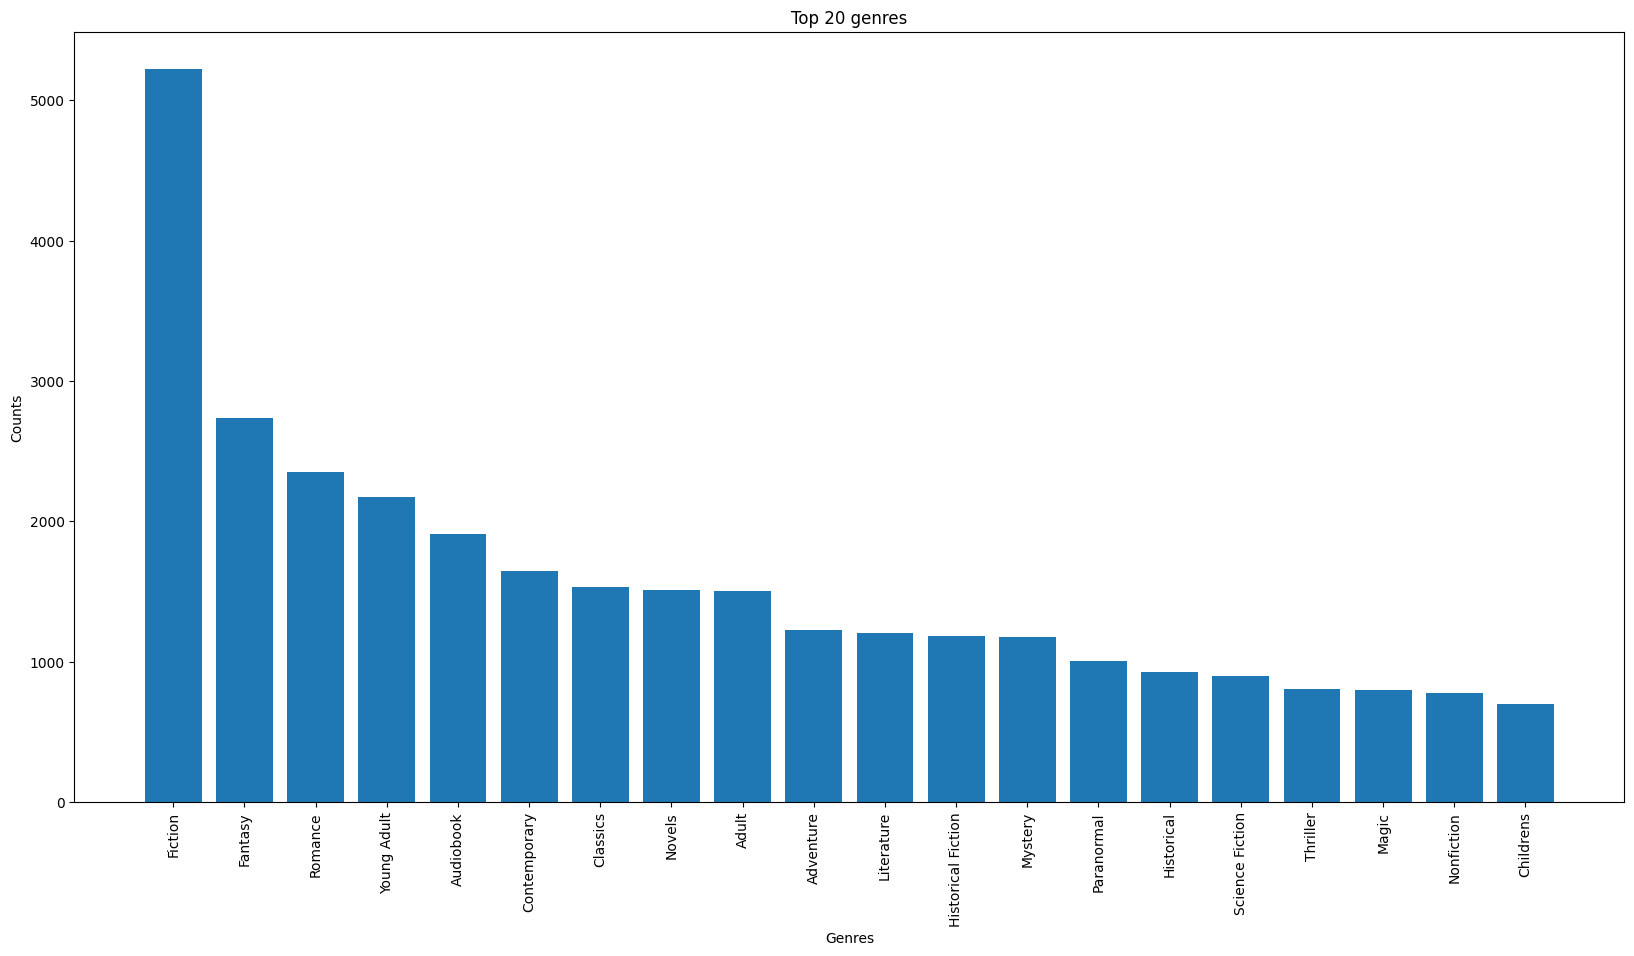

In [284]:
# Visualize top 20 genres
plt.figure(figsize=(20, 10))
plt.bar(range(len(top_20_genres)), [val[1] for val in top_20_genres], align='center')
plt.xticks(range(len(top_20_genres)), [val[0] for val in top_20_genres])
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.title('Top 20 genres')
plt.show()

*Thêm 20 thể loại phổ biến nhất vào tập dữ liệu*

In [285]:
top_20_genres_col = [genre[0] for genre in top_20_genres]

# Tạo cột cho mỗi thể loại
for genre in top_20_genres_col:
    X_train[genre] = X_train['genres'].apply(lambda x: 1 if genre in x else 0)
    X_val[genre] = X_val['genres'].apply(lambda x: 1 if genre in x else 0)
    X_test[genre] = X_test['genres'].apply(lambda x: 1 if genre in x else 0)

pd.set_option('display.max_columns', None)

X_train.head()

,title,author,language,ratings_count,reviews_count,publisher,publish_year,num_pages,page_format,genres,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Classics,Novels,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Historical,Science Fiction,Thriller,Magic,Nonfiction,Childrens
7003,Until Friday Night,Abbi Glines,English,60584,5405,Simon Pulse,2015.0,336.0,ebook,"Contemporary,Contemporary Romance,Fiction,High...",1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4062,Bad Science,Ben Goldacre,English,42034,2156,HarperCollins Publishers,2008.0,338.0,Paperback,"Audiobook,Health,Humor,Medical,Medicine,Nonfic...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4239,Cut,Patricia McCormick,English,57237,2960,Push,2002.0,151.0,Paperback,"Contemporary,Drama,Fiction,Mental Health,Menta...",1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
9463,Night Whispers,Erin Hunter,English,12988,360,HarperCollins,2010.0,352.0,Hardcover,"Action,Adventure,Animal Fiction,Animals,Cats,C...",1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
4142,The Hazel Wood,Melissa Albert,English,87888,13586,Flatiron Books,2018.0,359.0,Hardcover,"Audiobook,Fairy Tales,Fantasy,Fiction,Magic,Ma...",1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0


*Hàm tạo thêm các đặc trưng mới (title_count, title_length, publisher_count, rating_review_ratio, books_by_author, is_famous_author) và xóa các cột không cần thiết (title, author, publisher, language, genres)*

In [286]:
def addNewFeatures(data):
    data['title_count'] = data.groupby('title')['title'].transform('count')
    data.loc[data['reviews_count'] == 0, 'reviews_count'] = 1
    data['title_length'] = data['title'].apply(lambda x: len(x))
    data['publisher_count'] = data.groupby('publisher')['publisher'].transform('count')
    data['rating_review_ratio'] = data['ratings_count'] / data['reviews_count']
    data['books_by_author'] = data.groupby('author')['author'].transform('count')
    data['is_famous_author'] = data['books_by_author'].apply(lambda x: 1 if x > 10 else 0)

    drops = ['title', 'genres', 'author', 'publisher', 'language']
    for col in drops:
        data.drop([col], axis=1, inplace=True)

*Tạo thêm đặc trưng mới cho 3 tập dữ liệu*

In [287]:
addNewFeatures(X_train)
addNewFeatures(X_val)
addNewFeatures(X_test)

X_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Classics,Novels,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Historical,Science Fiction,Thriller,Magic,Nonfiction,Childrens,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
7003,60584,5405,2015.0,336.0,ebook,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,18,46.0,11.208881,12,1
4062,42034,2156,2008.0,338.0,Paperback,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,11,31.0,19.496289,1,0
4239,57237,2960,2002.0,151.0,Paperback,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,3,1.0,19.336824,1,0
9463,12988,360,2010.0,352.0,Hardcover,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,14,91.0,36.077778,24,1
4142,87888,13586,2018.0,359.0,Hardcover,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,14,12.0,6.469012,1,0


*Chuyển đổi cột dữ liệu 'page_format' về dạng số*

In [288]:
cols = ['page_format']
for col in cols:
    X_train, X_val, X_test = string_to_num(X_train, X_val, X_test, col)

X_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Classics,Novels,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Historical,Science Fiction,Thriller,Magic,Nonfiction,Childrens,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
7003,60584,5405,2015.0,336.0,24,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,18,46.0,11.208881,12,1
4062,42034,2156,2008.0,338.0,15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,11,31.0,19.496289,1,0
4239,57237,2960,2002.0,151.0,15,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,3,1.0,19.336824,1,0
9463,12988,360,2010.0,352.0,8,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,14,91.0,36.077778,24,1
4142,87888,13586,2018.0,359.0,8,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,14,12.0,6.469012,1,0


*Trực quan hóa các đặc trưng với nhãn (avg_ratings)*

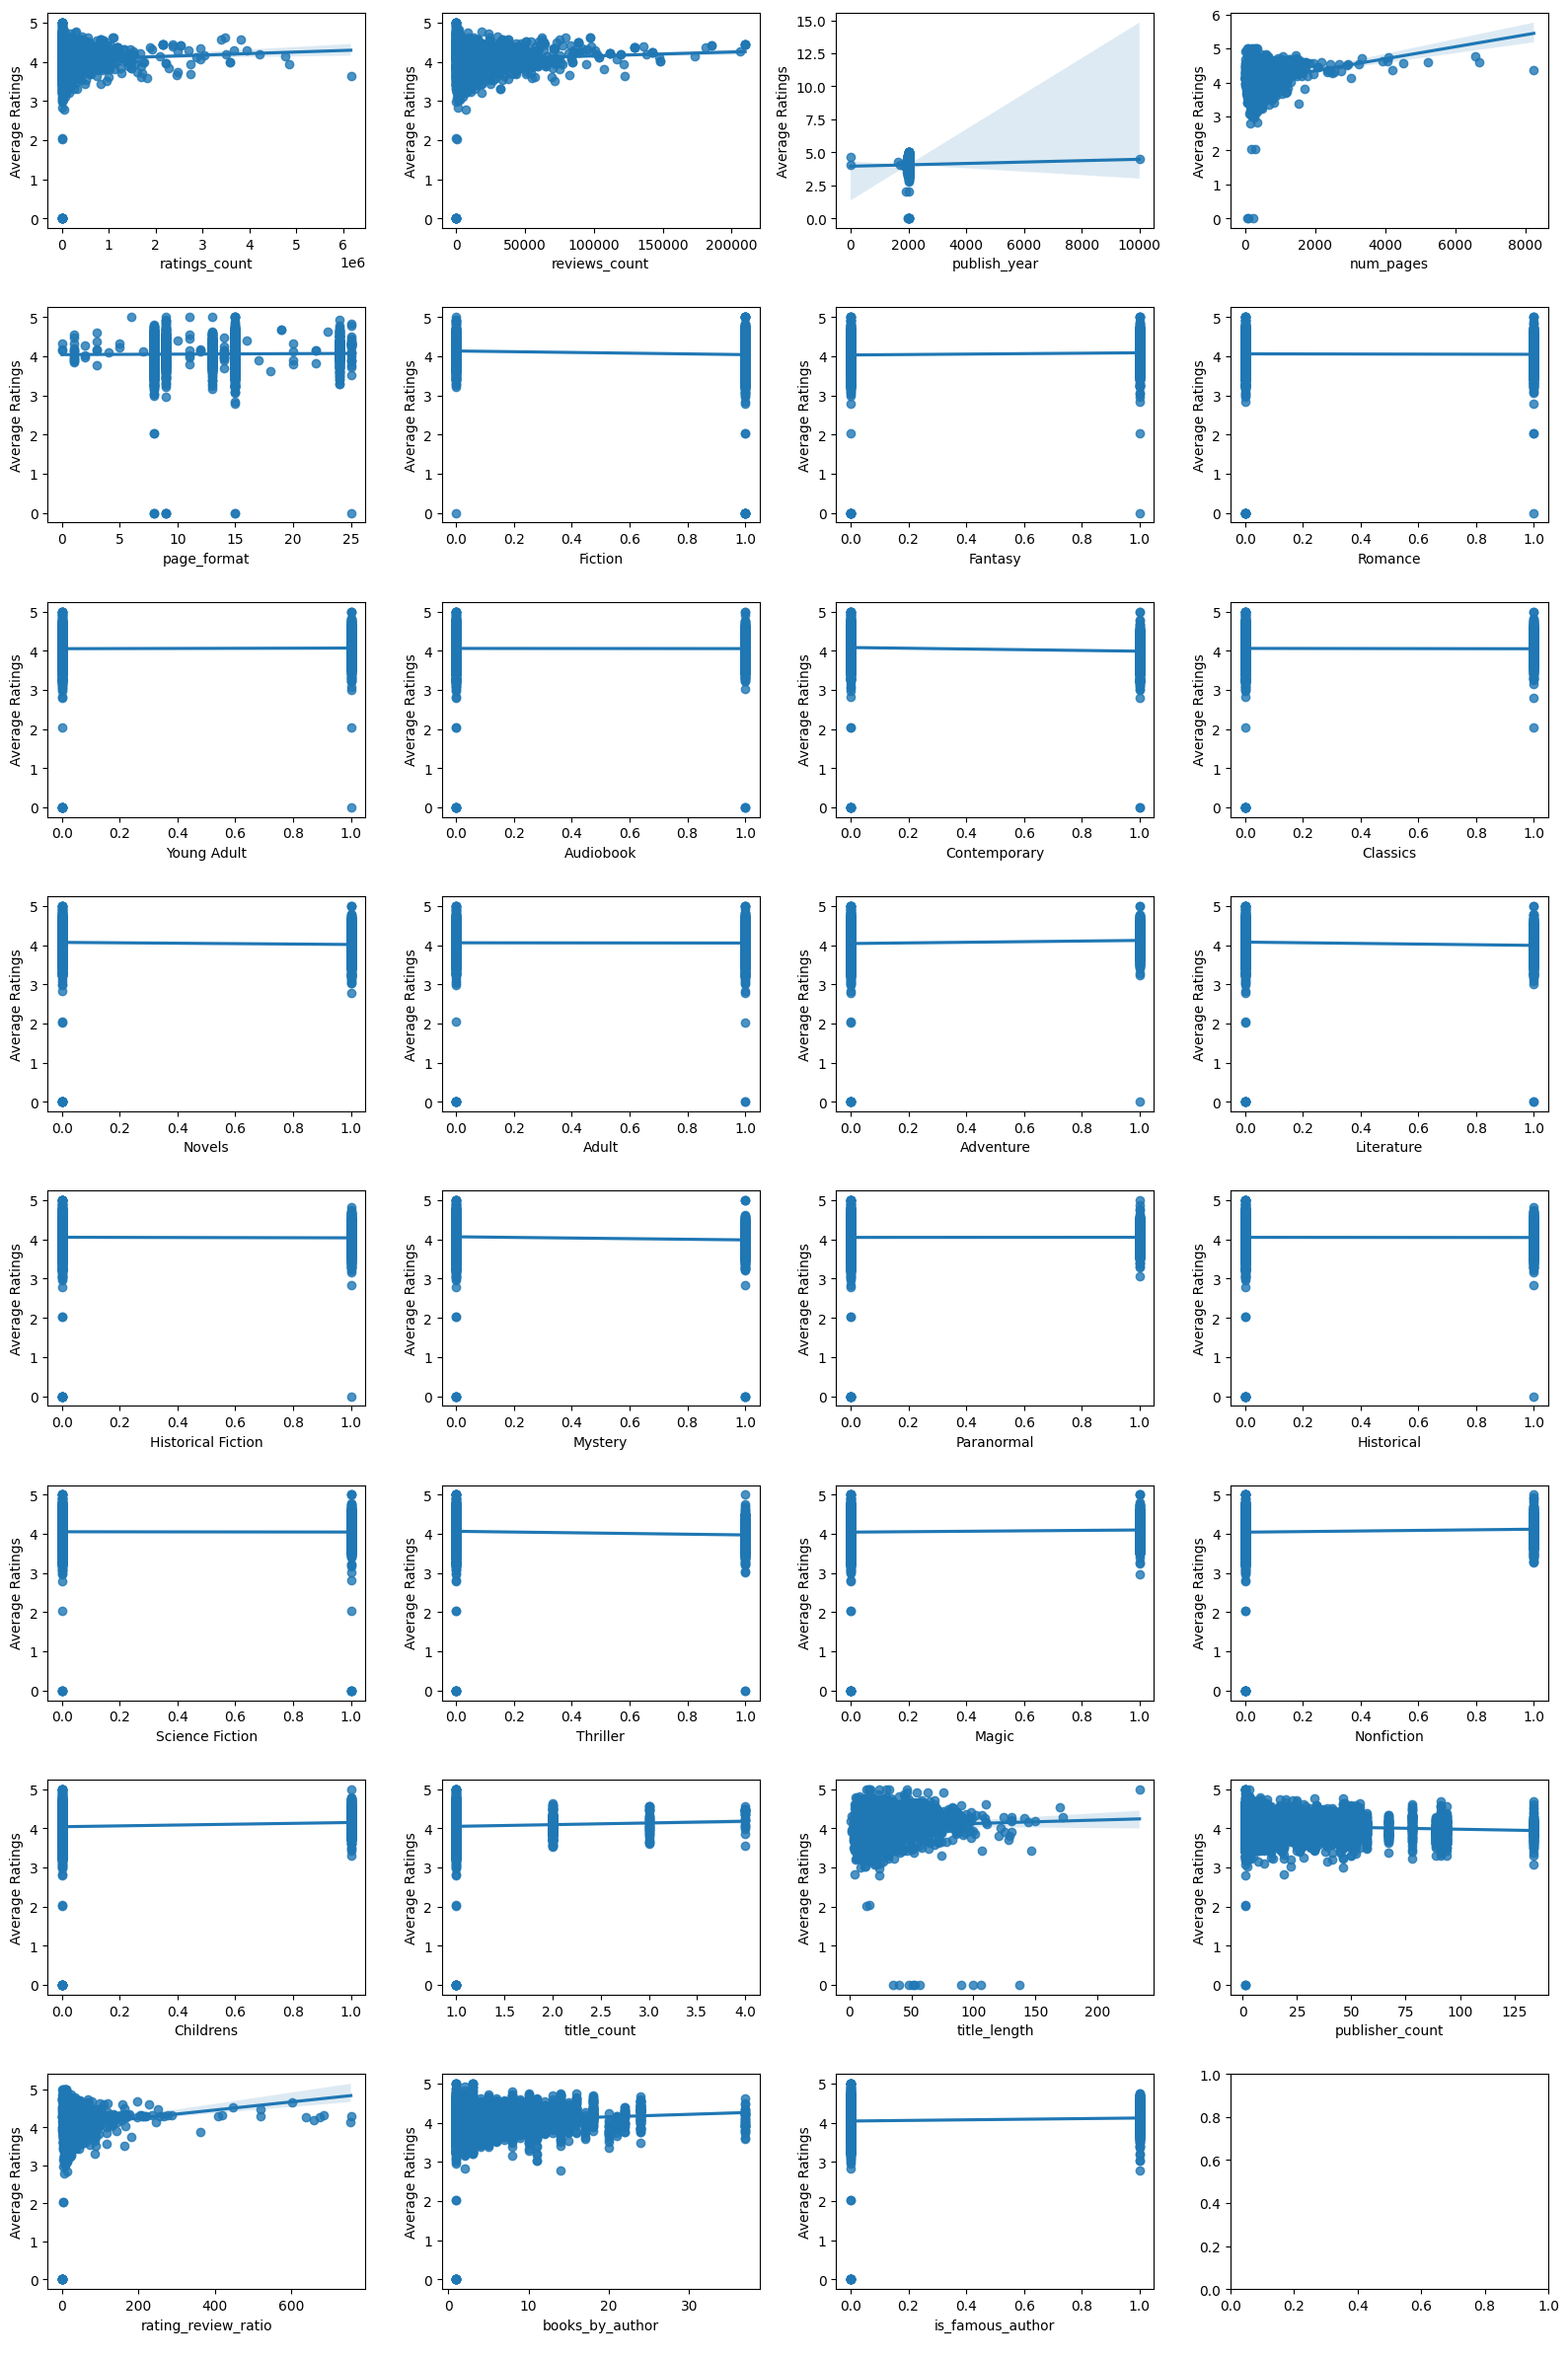

In [289]:
data_train = pd.concat([X_train, y_train], axis=1)
cols = data_train.columns.tolist()
cols.remove('avg_ratings')
cols_len = len(cols)
num_rows = cols_len // 4 + 1
fig, ax = plt.subplots(num_rows, 4, figsize=(16, 24))
for i in range(cols_len):
    sns.regplot(x=cols[i], y='avg_ratings', data=data_train, ax=ax[i // 4][i % 4])
    ax[i // 4][i % 4].set_xlabel(cols[i] + '\n')
    ax[i // 4][i % 4].set_ylabel('Average Ratings')

plt.tight_layout()
plt.show()

*Heatmap thể hiện sự tương quan giữa nhãn (avg_ratings) và các đặc trưng*

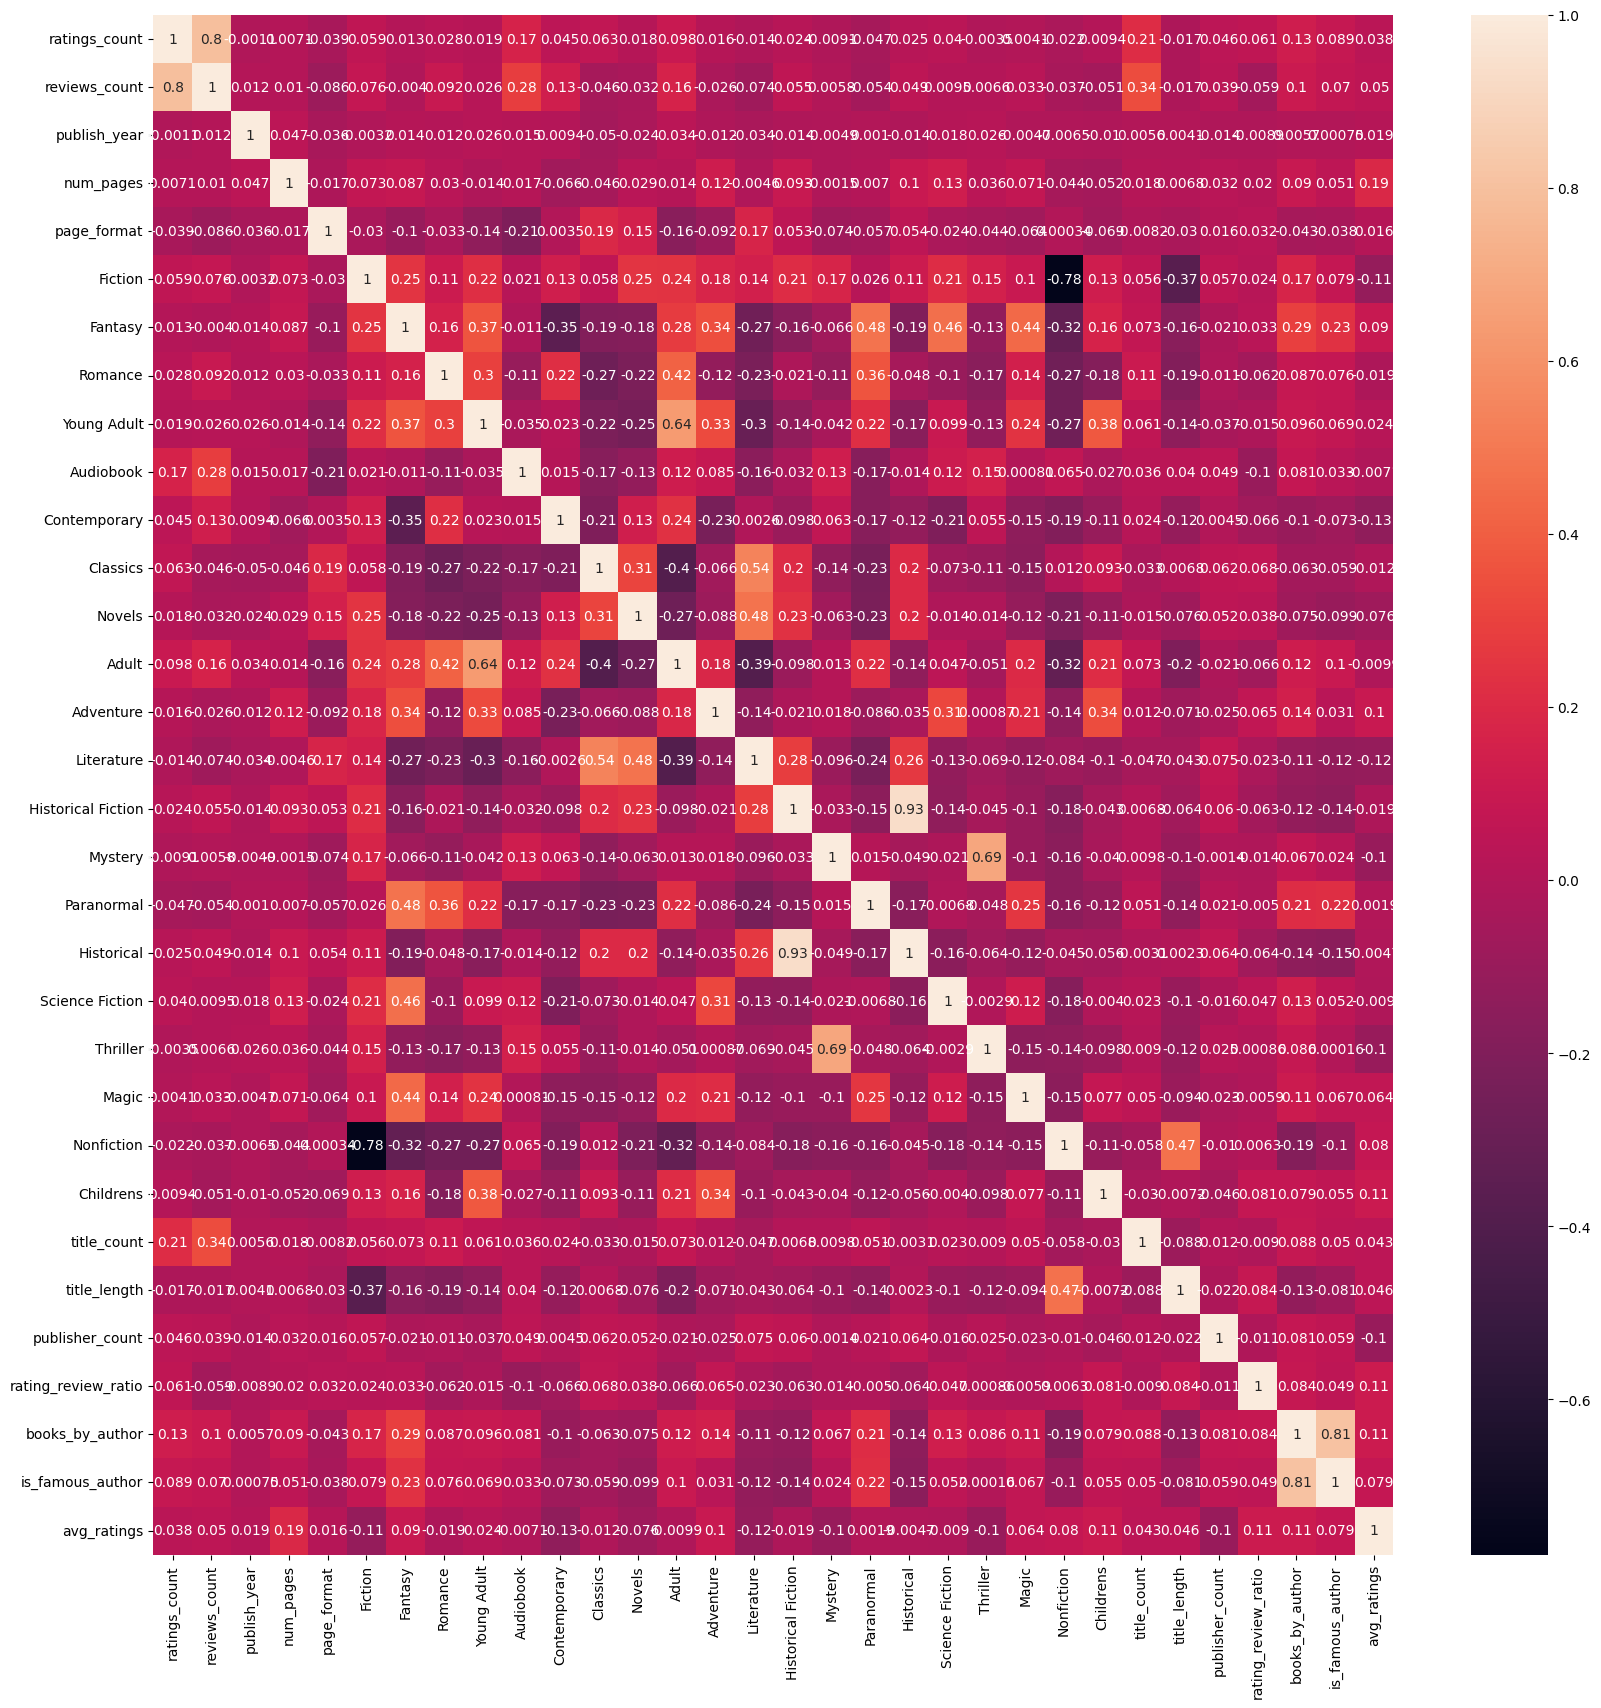

In [290]:
def plot_heatmap(data):
    corr = data.corr()
    plt.figure(figsize=(20, 20))

    sns.heatmap(corr, annot=True)
    plt.show()

plot_heatmap(data_train)

*Lấy ra các đặc trưng có độ tương quan cao với nhãn (avg_ratings)*

In [291]:
corr = data_train.corr()
corr['avg_ratings'].sort_values(ascending=False)

avg_ratings            1.000000
num_pages              0.193373
rating_review_ratio    0.113148
books_by_author        0.111910
Childrens              0.109017
Adventure              0.100966
Fantasy                0.090198
Nonfiction             0.080413
is_famous_author       0.079396
Magic                  0.063811
reviews_count          0.049677
title_length           0.046310
title_count            0.042577
ratings_count          0.037689
Young Adult            0.023600
publish_year           0.018624
page_format            0.015673
Paranormal             0.001940
Historical            -0.004666
Audiobook             -0.007074
Science Fiction       -0.008980
Adult                 -0.009853
Classics              -0.012462
Historical Fiction    -0.018670
Romance               -0.018772
Novels                -0.075528
Mystery               -0.100159
Thriller              -0.102130
publisher_count       -0.102283
Fiction               -0.112876
Literature            -0.118437
Contempo

*Kiểm tra dữ liệu trống*

In [292]:
X_train.isnull().sum()

ratings_count            0
reviews_count            0
publish_year            42
num_pages               80
page_format              0
Fiction                  0
Fantasy                  0
Romance                  0
Young Adult              0
Audiobook                0
Contemporary             0
Classics                 0
Novels                   0
Adult                    0
Adventure                0
Literature               0
Historical Fiction       0
Mystery                  0
Paranormal               0
Historical               0
Science Fiction          0
Thriller                 0
Magic                    0
Nonfiction               0
Childrens                0
title_count              0
title_length             0
publisher_count        231
rating_review_ratio      0
books_by_author          0
is_famous_author         0
dtype: int64

*Xử lí dữ liệu trống với các cột (publish_year, num_pages, publisher_count)*

In [293]:
X_train, X_val, X_test = fillMissingData(X_train, X_val, X_test)
X_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Classics,Novels,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Historical,Science Fiction,Thriller,Magic,Nonfiction,Childrens,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
7003,60584,5405,2015.0,336.0,24,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,18,46.0,11.208881,12,1
4062,42034,2156,2008.0,338.0,15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,11,31.0,19.496289,1,0
4239,57237,2960,2002.0,151.0,15,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,3,1.0,19.336824,1,0
9463,12988,360,2010.0,352.0,8,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,14,91.0,36.077778,24,1
4142,87888,13586,2018.0,359.0,8,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,14,12.0,6.469012,1,0


*Vẽ biểu đồ phân phối và biểu đồ box để xác định ngoại lệ của dữ liệu*

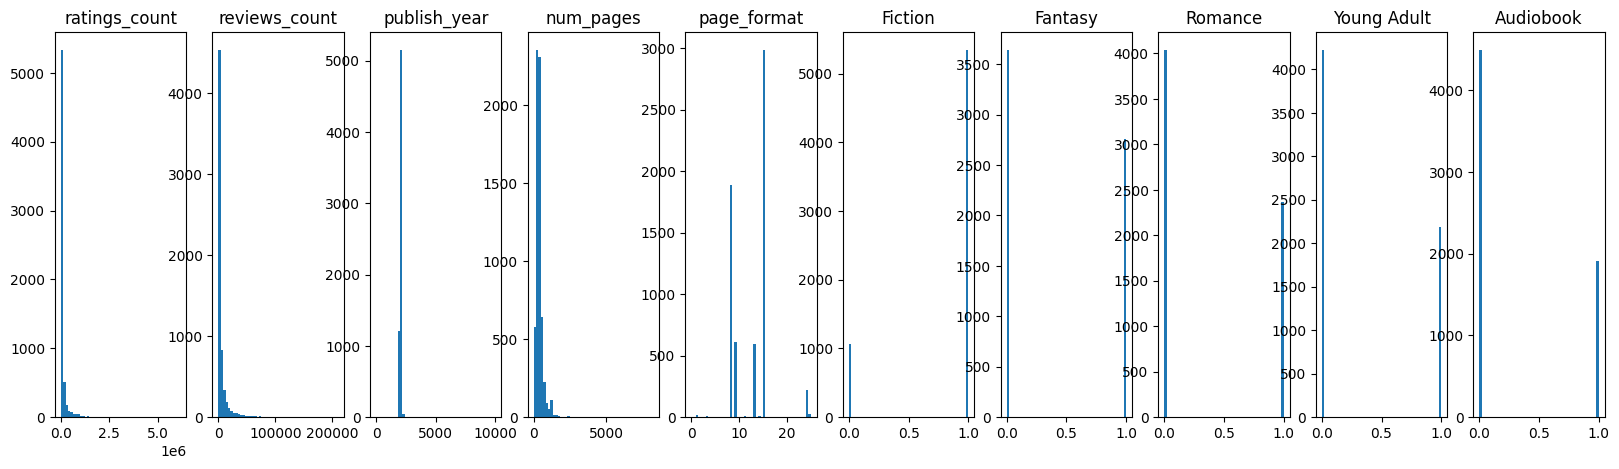

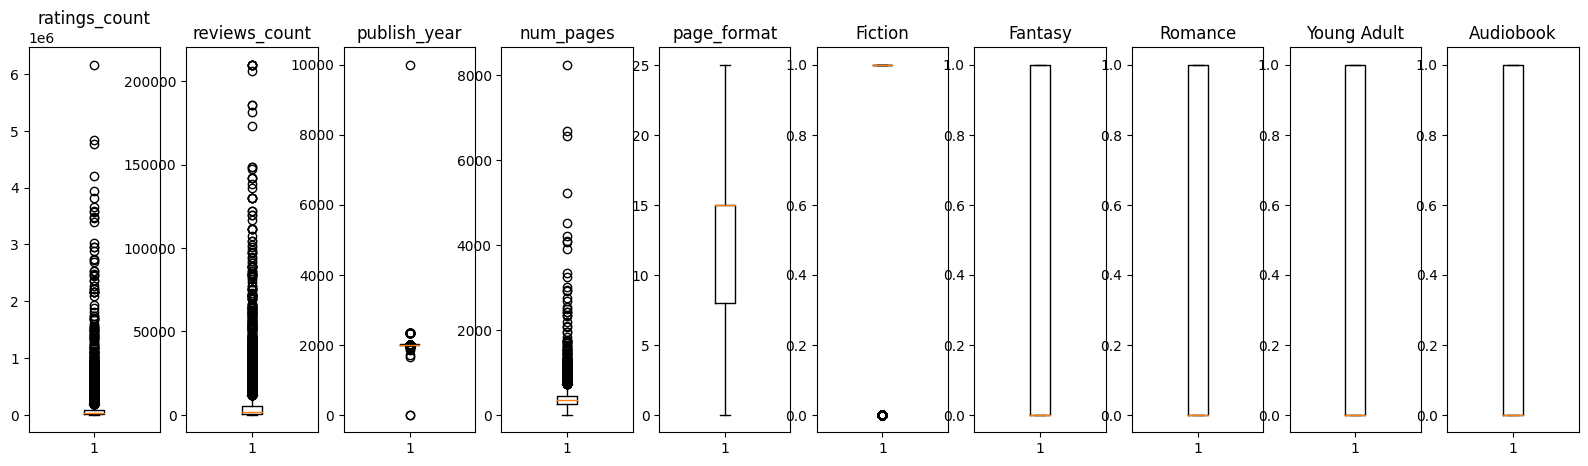

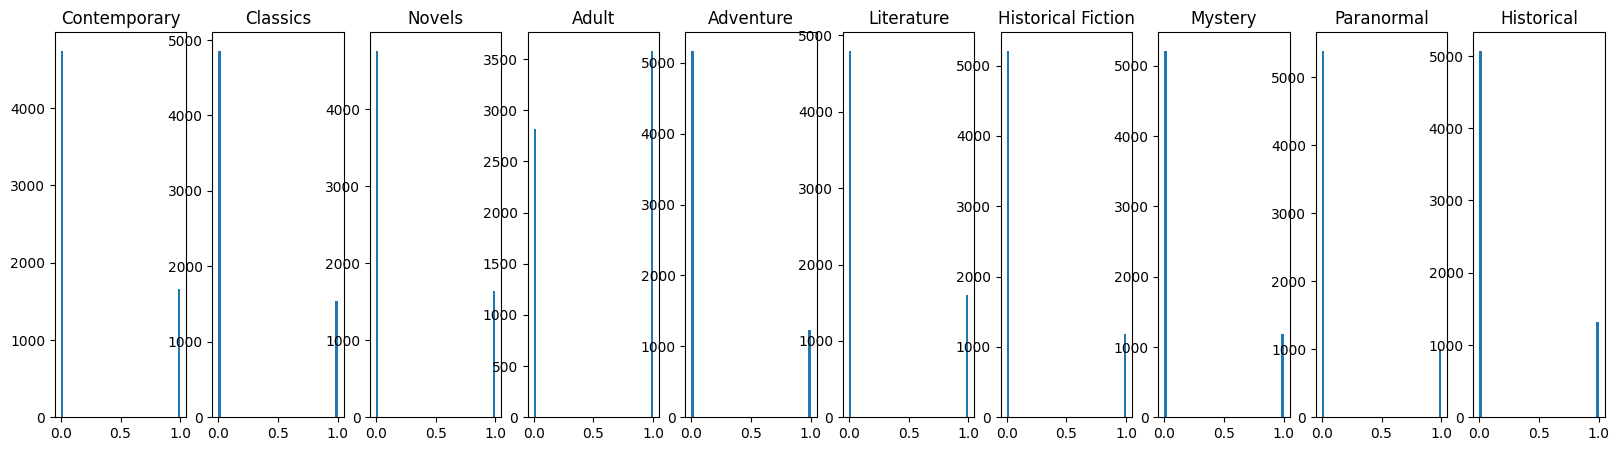

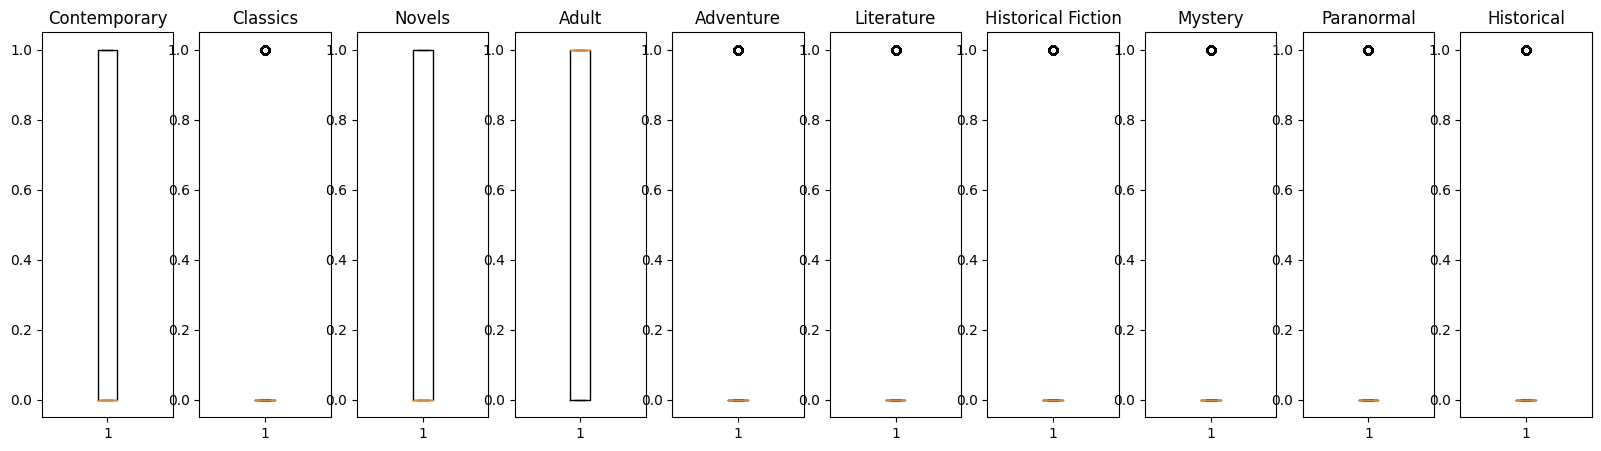

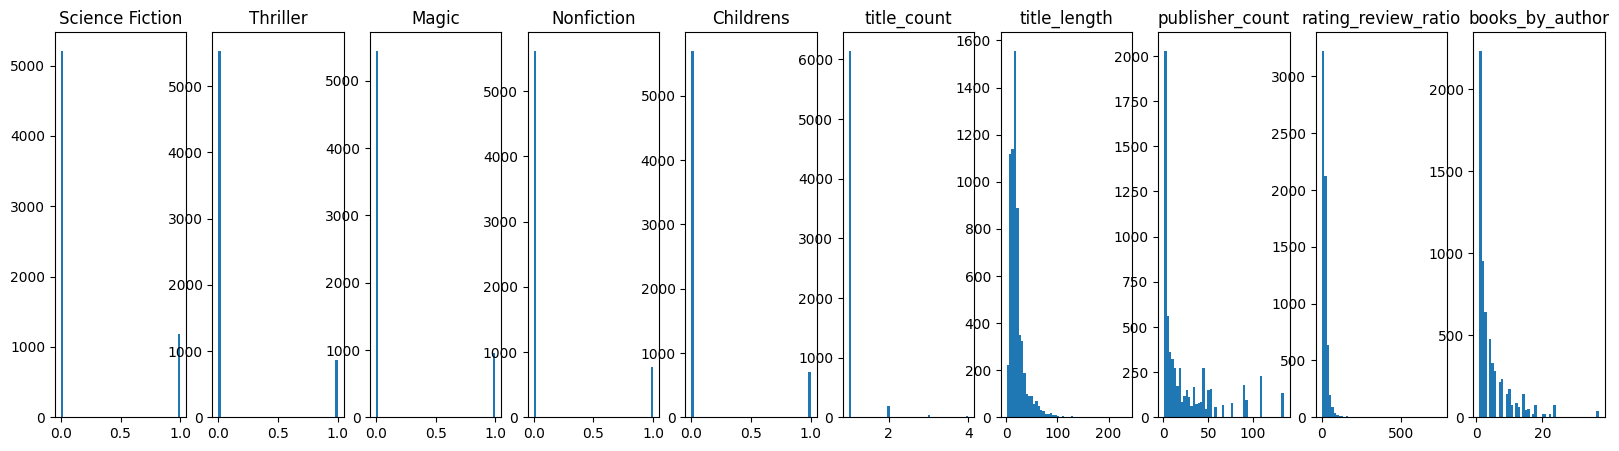

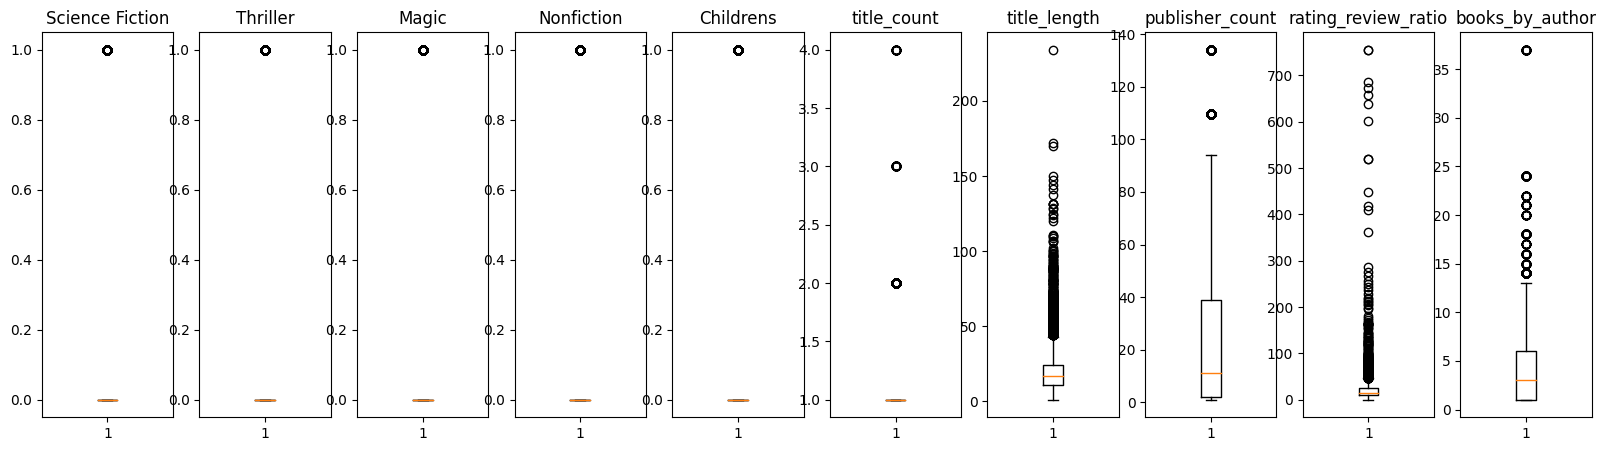

In [294]:
cols = X_train.columns
for i in range(0, 3):
    plotDistribution(X_train, cols[i*10: (i+1)*10])
    plotBox(X_train, cols[i*10: (i+1)*10])

*Nhận xét:*
- Từ các biểu đồ trên ta thấy hầu hết các đặc trưng đều có nhiều ngoại lệ và phân phối không đều.
- Đa số các ngoại lệ này có dạng phân phối lệch
- Các đặc trưng có ngoại lệ bao gồm: ratings_count, reviews_count, publish_year, num_pages, Fiction, Classics, Adventure,
       Mystery, Historical Fiction, Literature, Paranormal, Historical, Science Fiction, Thriller, Magic, Nonfiction, Childrens, 
       title_count, publisher_count, rating_review_ratio, books_by_author, title_length

In [295]:
skewedDists = ['ratings_count', 'reviews_count', 'publish_year', 'num_pages', 'Fiction', 'Classics', 'Adventure',
       'Mystery', 'Historical Fiction', 'Literature', 'Paranormal', 'Historical', 'Science Fiction', 'Thriller', 
       'Magic', 'Nonfiction', 'Childrens', 'title_count', 'publisher_count', 'rating_review_ratio', 'books_by_author', 'title_length']
isUpper_bridge = [True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
skewedDists = {col: isUpper_bridge for col, isUpper_bridge in zip(skewedDists, isUpper_bridge)}
gaussionDists = []
isUpper_boundary = []
gaussionDists = {col: isUpper_boundary for col, isUpper_boundary in zip(gaussionDists, isUpper_boundary)}

*Xử lí ngoại lệ*

In [296]:
X_train, X_val, X_test = handleOutlier(X_train, X_val, X_test, skewedDists, gaussionDists)
X_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Classics,Novels,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Historical,Science Fiction,Thriller,Magic,Nonfiction,Childrens,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
7003,60584.0,5405,2015.0,336.0,24,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,18,46.0,11.208881,12,1
4062,42034.0,2156,2008.0,338.0,15,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11,31.0,19.496289,1,0
4239,57237.0,2960,2002.0,151.0,15,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,3,1.0,19.336824,1,0
9463,12988.0,360,2010.0,352.0,8,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,14,91.0,36.077778,21,1
4142,87888.0,13586,2018.0,359.0,8,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,14,12.0,6.469012,1,0


*Vẽ biểu đồ phân phối sau khi xử lí ngoại lệ*

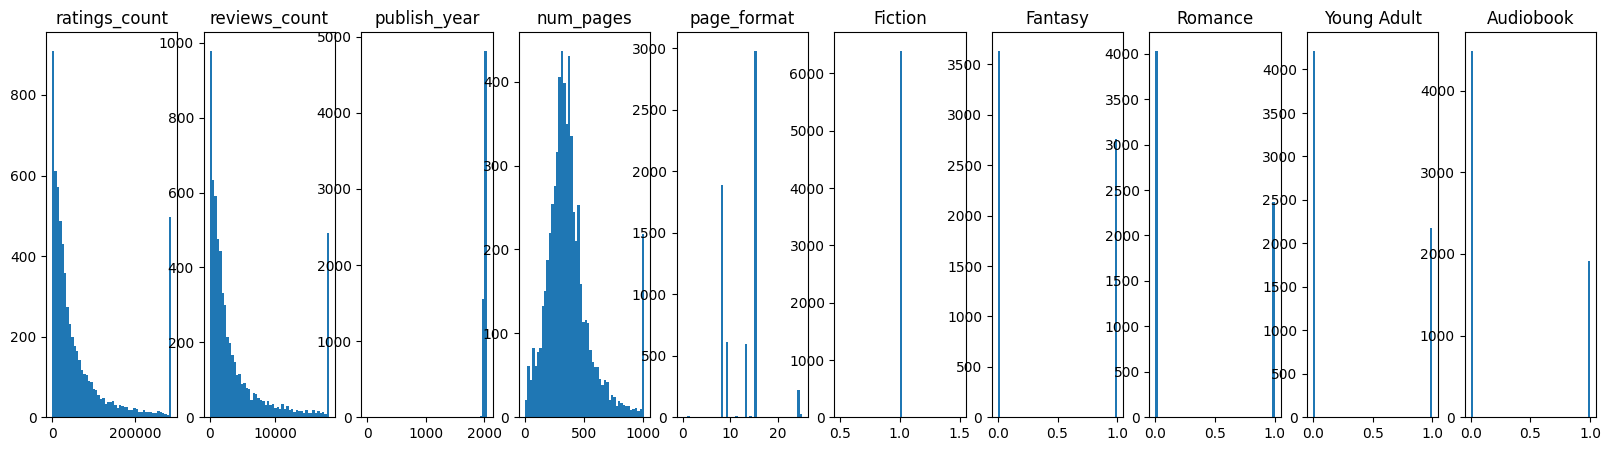

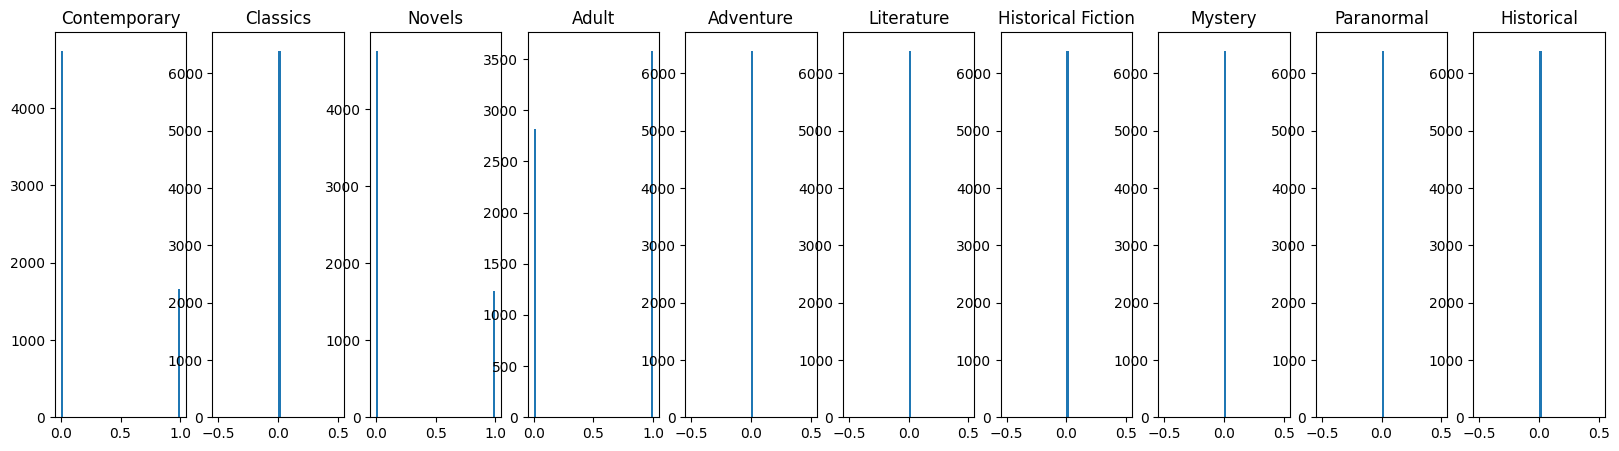

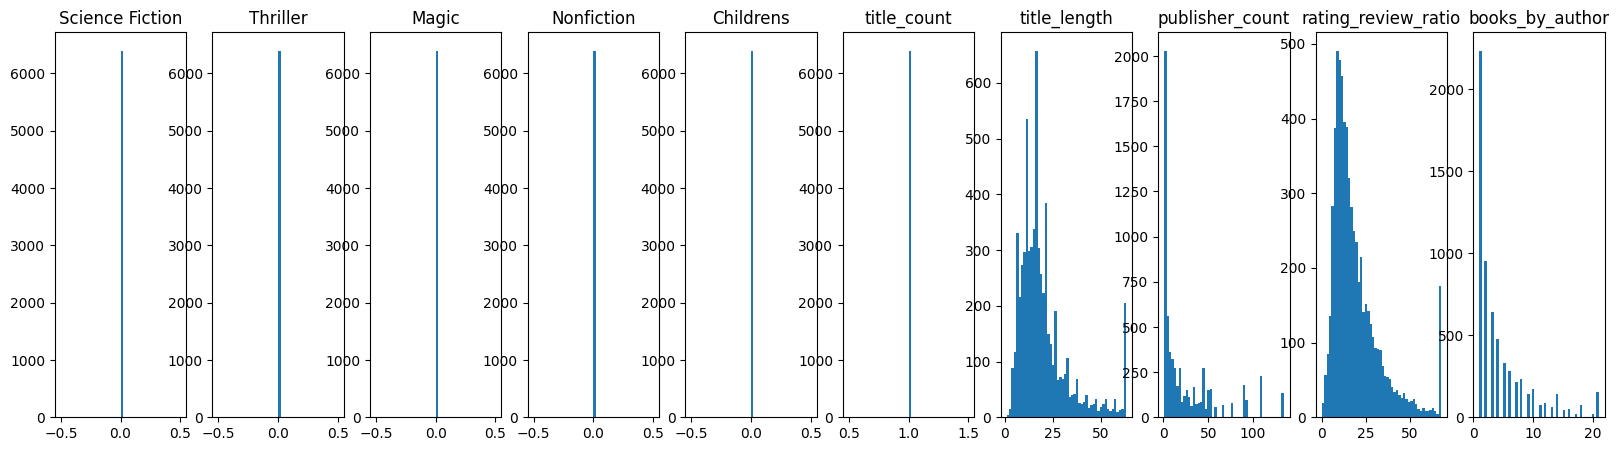

In [297]:
cols = X_train.columns
for i in range(0, 3):
    plotDistribution(X_train, cols[i*10: (i+1)*10])

*Nhận xét:*
- Sau khi xử lí ngoại lệ, phân phối của các đặc trưng đã được cải thiện đáng kể
- Tuy nhiên, vẫn còn một số đặc trưng có phân phối không đều và có nhiều ngoại lệ (ratings_count, reviews_count, publish_year, ...)

*Chuẩn hóa dữ liệu với PowerTransformer*

In [298]:
X_train, X_val, X_test = scaleData(X_train, X_val, X_test, PowerTransformer())
X_train.head()

,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Classics,Novels,Adult,Adventure,Literature,Historical Fiction,Mystery,Paranormal,Historical,Science Fiction,Thriller,Magic,Nonfiction,Childrens,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
0,0.403950,0.693417,0.798047,-0.071480,2.496649,8.881784e-16,-0.871288,1.305866,1.390510,-0.652121,1.692885,0.0,-0.586856,0.886372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.881784e-16,0.131268,1.020259,-0.501764,1.447743,2.808222
1,0.138715,0.027903,0.041830,-0.060487,0.678419,8.881784e-16,-0.871288,-0.765775,-0.719161,1.533458,-0.590707,0.0,-0.586856,-1.128195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.881784e-16,-0.702843,0.752008,0.318326,-1.139139,-0.356097
2,0.361205,0.243440,-0.554457,-1.323114,0.678419,8.881784e-16,-0.871288,-0.765775,1.390510,-0.652121,1.692885,0.0,1.703995,0.886372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.881784e-16,-2.874610,-1.353931,0.305933,-1.139139,-0.356097
3,-0.574367,-0.958690,0.251018,0.015445,-1.151717,8.881784e-16,1.147727,-0.765775,1.390510,-0.652121,-0.590707,0.0,-0.586856,0.886372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.881784e-16,-0.292594,1.475993,1.261549,1.791037,2.808222
4,0.698340,1.498758,1.143452,0.052767,-1.151717,8.881784e-16,1.147727,-0.765775,1.390510,1.533458,-0.590707,0.0,-0.586856,0.886372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.881784e-16,-0.292594,0.101532,-1.275952,-1.139139,-0.356097


*Vẽ biểu đồ phân phối sau khi chuẩn hóa dữ liệu*

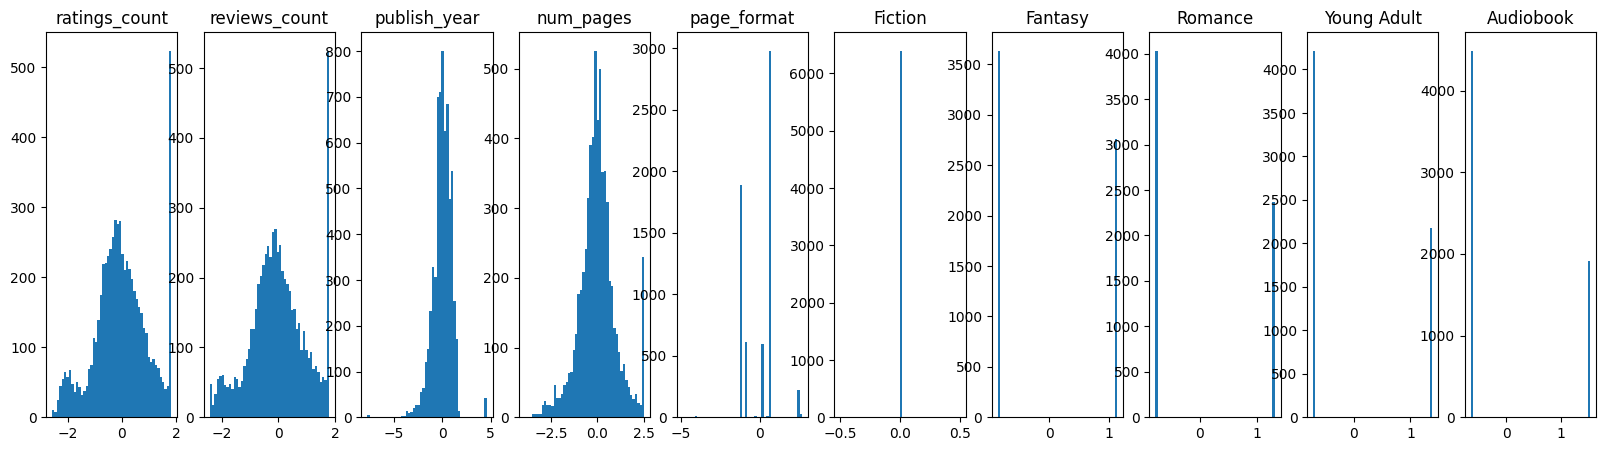

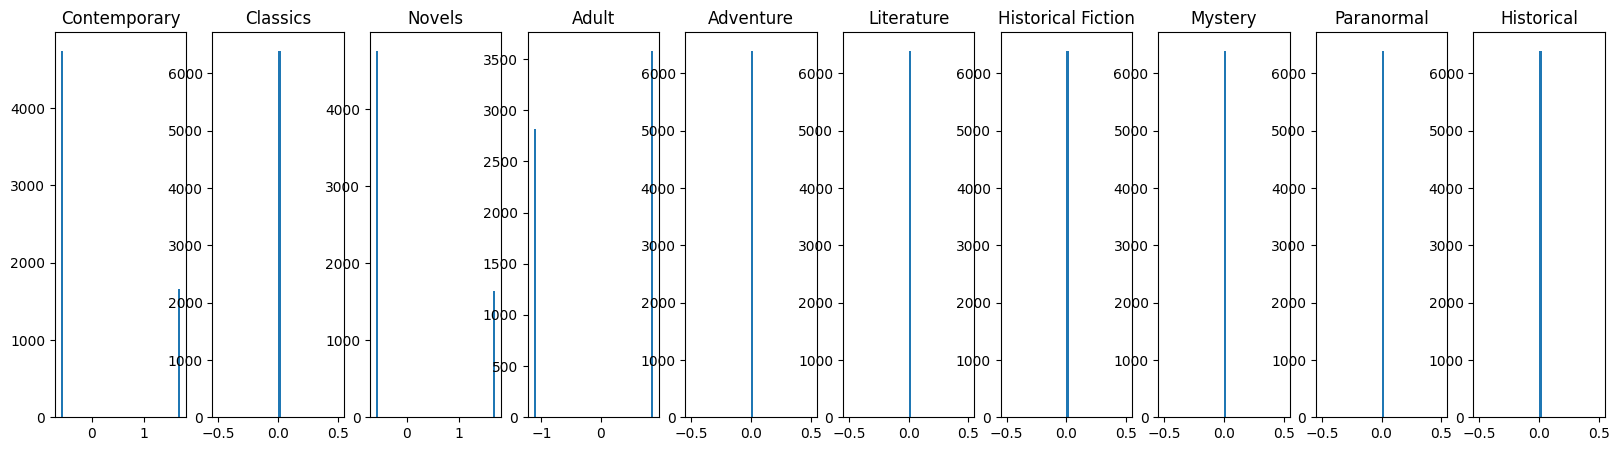

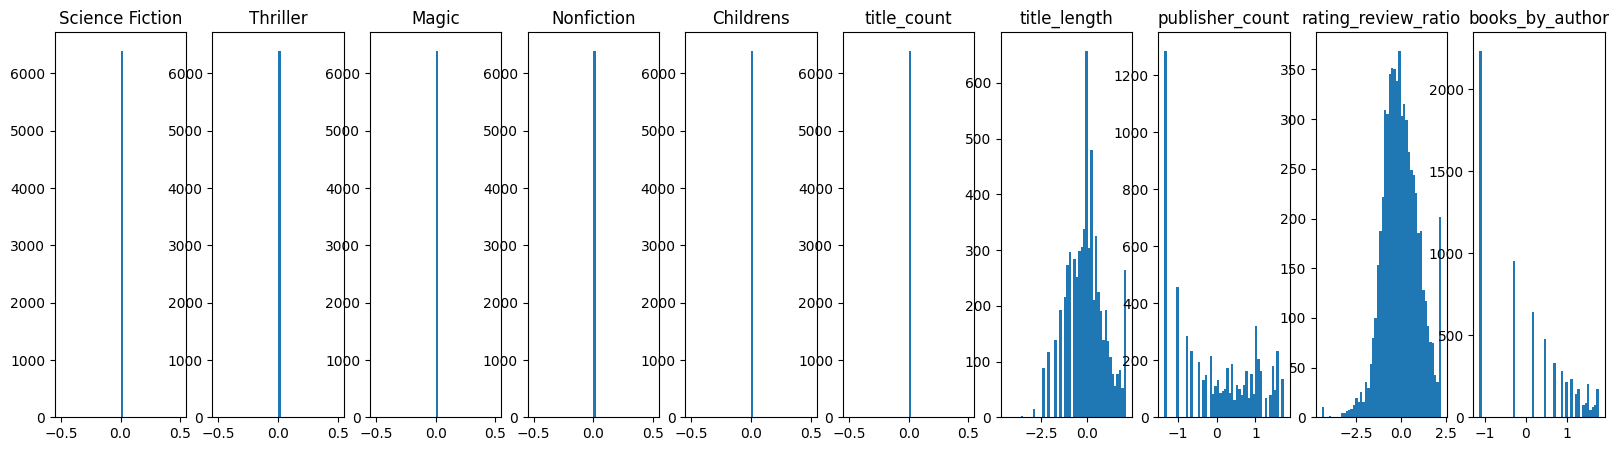

In [299]:
cols = X_train.columns
for i in range(0, 3):
    plotDistribution(X_train, cols[i*10: (i+1)*10])

*Nhận xét:*
- Sau khi chuẩn hóa dữ liệu, phân phối của các đặc trưng đã được cải thiện đáng kể đặc biệt là các đặc trưng như là: ratings_count, reviews_count, publish_year, num_pages, ...
- Tuy nhiên, vẫn còn một số đặc trưng có phân phối không đều và có nhiều ngoại lệ
- Đặc biệt, các đặc trưng như là: Fiction, Classis, Adventure, Literature, Historical Fiction, Literature, Paranormal, Historical, Science Fiction, Thriller, Magic, Nonfiction, Childrens, title_count có giá trị gần bằng 0. Điều này cho thấy các đặc trưng này không có tác dụng đối với nhãn (avg_ratings)

*Chọn đặc trưng với SelectKBest*

In [300]:
X_train_SF_SKB, X_val_SF_SKB, X_test_SF_SKB = selectFeatures_SelectKBest(X_train, y_train, X_val, X_test)
X_train_SF_SKB.head()

['ratings_count' 'reviews_count' 'publish_year' 'num_pages' 'page_format'
 'Fantasy' 'Romance' 'Young Adult' 'Audiobook' 'Contemporary' 'Novels'
 'Adult' 'title_count' 'title_length' 'publisher_count'
 'rating_review_ratio' 'books_by_author' 'is_famous_author']


,ratings_count,reviews_count,publish_year,num_pages,page_format,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Novels,Adult,title_count,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
0,0.403950,0.693417,0.798047,-0.071480,2.496649,-0.871288,1.305866,1.390510,-0.652121,1.692885,-0.586856,0.886372,8.881784e-16,0.131268,1.020259,-0.501764,1.447743,2.808222
1,0.138715,0.027903,0.041830,-0.060487,0.678419,-0.871288,-0.765775,-0.719161,1.533458,-0.590707,-0.586856,-1.128195,8.881784e-16,-0.702843,0.752008,0.318326,-1.139139,-0.356097
2,0.361205,0.243440,-0.554457,-1.323114,0.678419,-0.871288,-0.765775,1.390510,-0.652121,1.692885,1.703995,0.886372,8.881784e-16,-2.874610,-1.353931,0.305933,-1.139139,-0.356097
3,-0.574367,-0.958690,0.251018,0.015445,-1.151717,1.147727,-0.765775,1.390510,-0.652121,-0.590707,-0.586856,0.886372,8.881784e-16,-0.292594,1.475993,1.261549,1.791037,2.808222
4,0.698340,1.498758,1.143452,0.052767,-1.151717,1.147727,-0.765775,1.390510,1.533458,-0.590707,-0.586856,0.886372,8.881784e-16,-0.292594,0.101532,-1.275952,-1.139139,-0.356097


*Chọn đặc trưng với RFE*

In [301]:
X_train_SF, X_val_SF, X_test_SF = selectFeatures(X_train, y_train, X_val, X_test)
X_train_SF.head()

['ratings_count' 'reviews_count' 'publish_year' 'num_pages' 'page_format'
 'Fiction' 'Fantasy' 'Romance' 'Young Adult' 'Audiobook' 'Contemporary'
 'Novels' 'Adult' 'title_length' 'publisher_count' 'rating_review_ratio'
 'books_by_author' 'is_famous_author']


,ratings_count,reviews_count,publish_year,num_pages,page_format,Fiction,Fantasy,Romance,Young Adult,Audiobook,Contemporary,Novels,Adult,title_length,publisher_count,rating_review_ratio,books_by_author,is_famous_author
0,0.403950,0.693417,0.798047,-0.071480,2.496649,8.881784e-16,-0.871288,1.305866,1.390510,-0.652121,1.692885,-0.586856,0.886372,0.131268,1.020259,-0.501764,1.447743,2.808222
1,0.138715,0.027903,0.041830,-0.060487,0.678419,8.881784e-16,-0.871288,-0.765775,-0.719161,1.533458,-0.590707,-0.586856,-1.128195,-0.702843,0.752008,0.318326,-1.139139,-0.356097
2,0.361205,0.243440,-0.554457,-1.323114,0.678419,8.881784e-16,-0.871288,-0.765775,1.390510,-0.652121,1.692885,1.703995,0.886372,-2.874610,-1.353931,0.305933,-1.139139,-0.356097
3,-0.574367,-0.958690,0.251018,0.015445,-1.151717,8.881784e-16,1.147727,-0.765775,1.390510,-0.652121,-0.590707,-0.586856,0.886372,-0.292594,1.475993,1.261549,1.791037,2.808222
4,0.698340,1.498758,1.143452,0.052767,-1.151717,8.881784e-16,1.147727,-0.765775,1.390510,1.533458,-0.590707,-0.586856,0.886372,-0.292594,0.101532,-1.275952,-1.139139,-0.356097


*Nhận xét:*
- Các đặc trưng được chọn bởi SelectKBest và RFE là gần giống nhau và đều có độ tương quan cao với nhãn (avg_ratings)
- Với SelectKBest, ta chọn ra 18 đặc trưng có độ tương quan cao nhất với nhãn (avg_ratings): ratings_count, reviews_count, publish_year, num_pages, page_format,
Fantasy, Romance, Young Adult, Audiobook, Contemporary, Novels, Adult, title_count, title_length, publisher_count, rating_review_ratio, books_by_author,is_famous_author
- Với RFE, ta chọn ra 18 đặc trưng có độ tương quan cao nhất với nhãn (avg_ratings): ratings_count, reviews_count, publish_year, num_pages, page_format,
Fiction, Fantasy, Romance, Young Adult, Audiobook, Contemporary, Novels Adult, title_length, publisher_count, rating_review_ratio, books_by_author,is_famous_author